In [3]:
# Install dependencies
!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd
import numpy as np
import string
import math
from collections import Counter, defaultdict
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import multiprocessing
nltk.download('punkt_tab')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import pickle

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load data
file_path = '/content/drive/My Drive/clean_data.csv'
df = pd.read_csv(file_path, encoding='utf-8')
df.dropna(inplace=True)
print(f"Loaded {df.shape[0]} rows")

# Split dataset
from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['sentiment'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['sentiment'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
value_counts = df['sentiment'].value_counts()
print(value_counts)

Mounted at /content/drive
Loaded 1044205 rows
Train: 730943, Val: 156631, Test: 156631
sentiment
negative    796576
positive    247489
neutral        140
Name: count, dtype: int64


In [5]:
# Display few entries before preprocessing
print("Before Preprocessing (first 5 entries):")
print(df[['text', 'sentiment']].head())

# Preprocessing
stopwords_set = set(stopwords.words("english"))
stemmer = PorterStemmer()

def preprocess_tweet(tweet):
    tweet = tweet.lower().translate(str.maketrans("", "", string.punctuation))
    tokens = nltk.word_tokenize(tweet)
    return [stemmer.stem(t) for t in tokens if t not in stopwords_set]

def parallel_preprocess(df):
    with multiprocessing.Pool() as pool:
        df['tokens'] = pool.map(preprocess_tweet, df['clean_text'].tolist())
    return df

# Apply parallel preprocessing
train_df = parallel_preprocess(train_df)
val_df = parallel_preprocess(val_df)
test_df = parallel_preprocess(test_df)

# Display a few entries after preprocessing
print("\nAfter Preprocessing (first 5 entries):")
print(train_df[['clean_text', 'tokens', 'sentiment']].head())

Before Preprocessing (first 5 entries):
                                                text sentiment
0  @stellargirl I loooooooovvvvvveee my Kindle2. ...  positive
1  Reading my kindle2...  Love it... Lee childs i...  positive
2  Ok, first assesment of the #kindle2 ...it fuck...  positive
3  @kenburbary You'll love your Kindle2. I've had...  positive
4  @mikefish  Fair enough. But i have the Kindle2...  positive

After Preprocessing (first 5 entries):
                                                clean_text  \
56192                                             lutefest   
527488                   need go sleep work midnight shift   
1035267                                 cant wait see blog   
610332                                   boyfriend country   
956046   franzneits going head music come subconsciousq...   

                                                    tokens sentiment  
56192                                           [lutefest]  negative  
527488            [need, go

In [6]:

# Word frequency
def calculate_word_counts(token_lists):
    word_count = Counter()
    for tokens in token_lists:
        word_count.update(tokens)
    return word_count

word_count_positive = calculate_word_counts(train_df[train_df['sentiment'] == 'positive']['tokens'])
word_count_negative = calculate_word_counts(train_df[train_df['sentiment'] == 'negative']['tokens'])
word_count_neutral = calculate_word_counts(train_df[train_df['sentiment'] == 'neutral']['tokens'])

total_words_positive = sum(word_count_positive.values())
total_words_negative = sum(word_count_negative.values())
total_words_neutral = sum(word_count_neutral.values())

In [27]:
def calculate_log_likelihood(word_count, total_words, vocab_size, smoothing=1):
    log_likelihood = {
        word: math.log((count + smoothing) / (total_words + smoothing * vocab_size))
        for word, count in word_count.items()
    }
    default_log_prob = math.log(smoothing / (total_words + smoothing * vocab_size))
    return log_likelihood, default_log_prob

# Get vocabulary
vocab = set(word_count_positive) | set(word_count_negative) | set(word_count_neutral)
vocab_size = len(vocab)

# Log-likelihood
log_likelihood_positive, default_log_prob_pos = calculate_log_likelihood(word_count_positive, total_words_positive, vocab_size)
log_likelihood_negative, default_log_prob_neg = calculate_log_likelihood(word_count_negative, total_words_negative, vocab_size)
log_likelihood_neutral, default_log_prob_neu = calculate_log_likelihood(word_count_neutral, total_words_neutral, vocab_size)


# Log priors
def calculate_log_prior(sentiment, data):
    return math.log(len(data[data['sentiment'] == sentiment]) / len(data))

log_prior_positive = calculate_log_prior('positive', train_df)
log_prior_negative = calculate_log_prior('negative', train_df)
log_prior_neutral = calculate_log_prior('neutral', train_df)

In [28]:
def classify_tokens(tokens):
    score_pos = log_prior_positive + sum(log_likelihood_positive.get(t, default_log_prob_pos) for t in tokens)
    score_neg = log_prior_negative + sum(log_likelihood_negative.get(t, default_log_prob_neg) for t in tokens)
    score_neu = log_prior_neutral + sum(log_likelihood_neutral.get(t, default_log_prob_neu) for t in tokens)

    scores = {'positive': score_pos, 'negative': score_neg, 'neutral': score_neu}
    return max(scores, key=scores.get), scores


def predict_sentiments(df):
    return [classify_tokens(tokens)[0] for tokens in df['tokens']]

# Predictions
val_preds = predict_sentiments(val_df)
test_preds = predict_sentiments(test_df)



In [30]:
model_data = {
    'log_likelihood_positive': log_likelihood_positive,
    'log_likelihood_negative': log_likelihood_negative,
    'log_likelihood_neutral': log_likelihood_neutral,
    'default_log_prob_pos': default_log_prob_pos,
    'default_log_prob_neg': default_log_prob_neg,
    'default_log_prob_neu': default_log_prob_neu,
    'log_prior_positive': log_prior_positive,
    'log_prior_negative': log_prior_negative,
    'log_prior_neutral': log_prior_neutral,
    'vocab': vocab
}

with open('naive_bayes_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)


train_df.to_pickle("train_tokenized.pkl")
val_df.to_pickle("val_tokenized.pkl")
test_df.to_pickle("test_tokenized.pkl")


Validation Accuracy: 81.34%
Test Accuracy: 81.46%


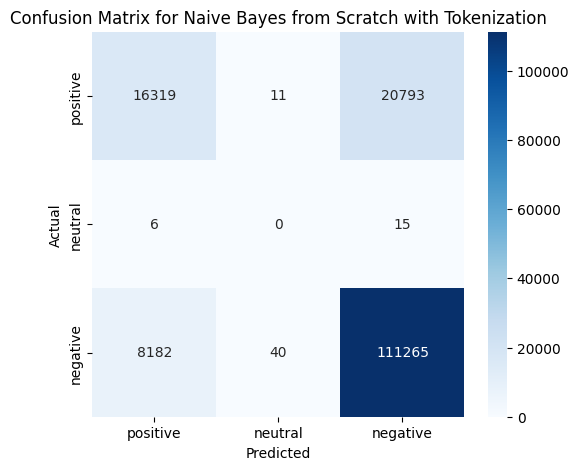

Classification Report (Test Set):
              precision    recall  f1-score   support

    positive       0.84      0.93      0.88    119487
     neutral       0.00      0.00      0.00        21
    negative       0.67      0.44      0.53     37123

    accuracy                           0.81    156631
   macro avg       0.50      0.46      0.47    156631
weighted avg       0.80      0.81      0.80    156631



In [29]:
# Accuracy and Report
val_acc = accuracy_score(val_df['sentiment'], val_preds)
test_acc = accuracy_score(test_df['sentiment'], test_preds)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Confusion matrix
cm = confusion_matrix(test_df['sentiment'], test_preds, labels=['positive', 'neutral', 'negative'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'neutral', 'negative'],
            yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Naive Bayes from Scratch with Tokenization')
plt.show()

print("Classification Report (Test Set):")
print(classification_report(test_df['sentiment'], test_preds, target_names=['positive', 'neutral', 'negative']))



In [10]:
def join_tokens(text):
    return " ".join(preprocess_tweet(text))

train_df['processed'] = train_df['text'].apply(join_tokens)
val_df['processed'] = val_df['text'].apply(join_tokens)
test_df['processed'] = test_df['text'].apply(join_tokens)

vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),  # unigrams + bigrams capture phrases like "not good"
    stop_words='english',
    sublinear_tf=True,   # use sublinear scaling
    norm='l2',           # keep consistent length vectors
    min_df=2
)
X_train = vectorizer.fit_transform(train_df['processed'])
X_val = vectorizer.transform(val_df['processed'])
X_test = vectorizer.transform(test_df['processed'])

y_train = train_df['sentiment']
y_val = val_df['sentiment']
y_test = test_df['sentiment']

In [14]:
# Fit the model first (before getting class priors)
clf = MultinomialNB()  # Initialize the classifier
clf.fit(X_train, y_train)  # Fit the model to the training data

# Compute class priors manually from the training set
class_counts = y_train.value_counts(normalize=True).to_dict()
priors = [class_counts.get(cls, 0) for cls in clf.classes_]

# Rebuild classifier with priors
clf_with_priors = MultinomialNB(class_prior=priors)
clf_with_priors.fit(X_train, y_train)  # Fit with the priors

# Predictions
val_preds_tfidf = clf_with_priors.predict(X_val)
test_preds_tfidf = clf_with_priors.predict(X_test)

# Accuracy
val_acc_tfidf = accuracy_score(y_val, val_preds_tfidf)
test_acc_tfidf = accuracy_score(y_test, test_preds_tfidf)

print(f"TF-IDF Validation Accuracy: {val_acc_tfidf * 100:.2f}%")
print(f"TF-IDF Test Accuracy: {test_acc_tfidf * 100:.2f}%")


TF-IDF Validation Accuracy: 81.12%
TF-IDF Test Accuracy: 81.30%


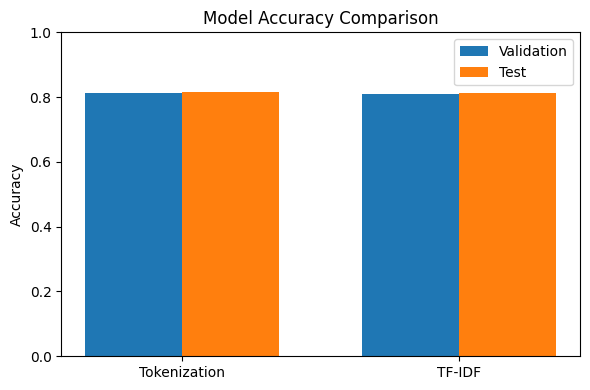

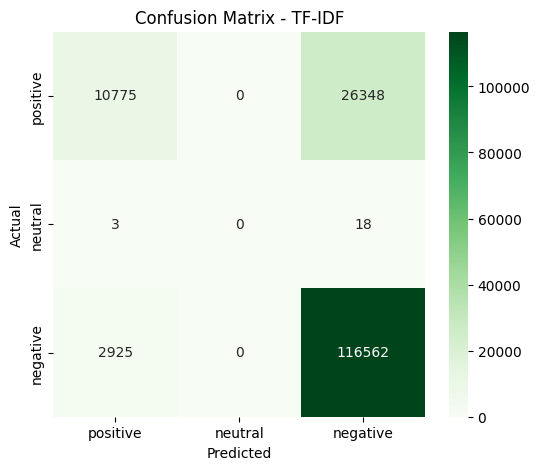

Sample: rudraksh won 40,000 in gambling
Predicted Sentiment (TF-IDF): negative


In [19]:
# Accuracy comparison
plt.figure(figsize=(6, 4))
methods = ['Tokenization', 'TF-IDF']
val_scores = [val_acc, val_acc_tfidf]
test_scores = [test_acc, test_acc_tfidf]

x = np.arange(len(methods))
width = 0.35
plt.bar(x - width/2, val_scores, width, label='Validation')
plt.bar(x + width/2, test_scores, width, label='Test')
plt.xticks(x, methods)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Confusion matrix - TF-IDF
cm = confusion_matrix(test_df['sentiment'], test_preds_tfidf, labels=['positive', 'neutral', 'negative'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['positive', 'neutral', 'negative'],
            yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TF-IDF')
plt.show()


# Sample prediction (TF-IDF)
def join_tokens(text):
    tokens = preprocess_tweet(text)
    return " ".join(tokens)

sample = "rudraksh won 40,000 in gambling"
sample_vec = vectorizer.transform([join_tokens(sample)])
sample_pred = clf.predict(sample_vec)[0]
print(f"Sample: {sample}\nPredicted Sentiment (TF-IDF): {sample_pred}")

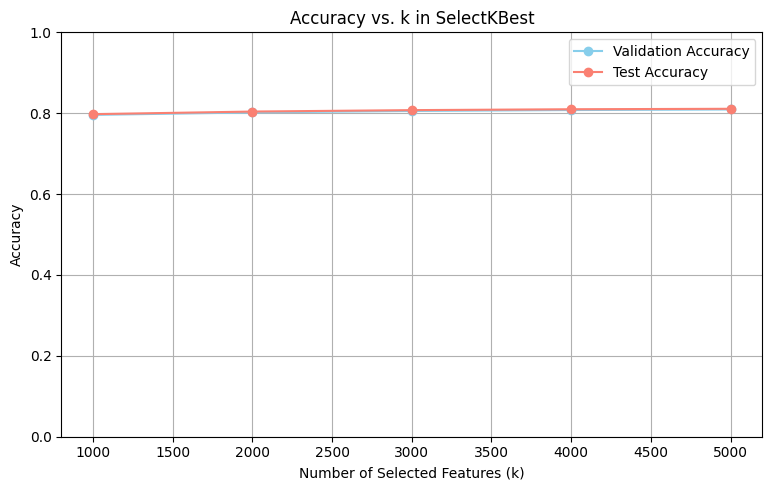

k-value | Validation Accuracy | Test Accuracy
---------------------------------------------
1000    | 0.7958              | 0.7977
2000    | 0.8020              | 0.8041
3000    | 0.8055              | 0.8076
4000    | 0.8078              | 0.8098
5000    | 0.8092              | 0.8109


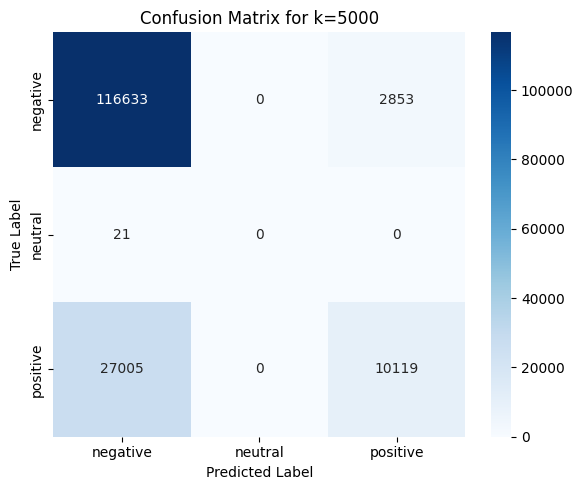

In [16]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import numpy as np

# Different values of k to try
k_values = [1000, 2000, 3000, 4000, 5000]

val_scores_kbest = []
test_scores_kbest = []

# Train and evaluate for each k
for k in k_values:
    kbest_selector = SelectKBest(chi2, k=k)
    X_train_k = kbest_selector.fit_transform(X_train, y_train)
    X_val_k = kbest_selector.transform(X_val)
    X_test_k = kbest_selector.transform(X_test)

    clf_k = MultinomialNB()
    clf_k.fit(X_train_k, y_train)

    val_preds_k = clf_k.predict(X_val_k)
    test_preds_k = clf_k.predict(X_test_k)

    val_acc_k = accuracy_score(y_val, val_preds_k)
    test_acc_k = accuracy_score(y_test, test_preds_k)

    val_scores_kbest.append(val_acc_k)
    test_scores_kbest.append(test_acc_k)

# ---------- Accuracy vs. k Plot ----------
plt.figure(figsize=(8, 5))
plt.plot(k_values, val_scores_kbest, marker='o', label='Validation Accuracy', color='skyblue')
plt.plot(k_values, test_scores_kbest, marker='o', label='Test Accuracy', color='salmon')
plt.xlabel('Number of Selected Features (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k in SelectKBest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(0, 1)
plt.show()

# ---------- Print Summary ----------
print("k-value | Validation Accuracy | Test Accuracy")
print("---------------------------------------------")
for i, k in enumerate(k_values):
    print(f"{k:<7} | {val_scores_kbest[i]:<19.4f} | {test_scores_kbest[i]:.4f}")
# Compute confusion matrix
cm = confusion_matrix(y_val, val_preds_k)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf_k.classes_, yticklabels=clf_k.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for k={k}')
plt.tight_layout()
plt.show()

In [17]:
import pickle

# Save the TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Save the trained Naive Bayes model
with open('nb_model_tfidf.pkl', 'wb') as f:
    pickle.dump(clf, f)
